##  Age-structured SIRS model for UK

 Assume that the population has been partitioned into  $i=1,\ldots, M$ age groups and that we have available the $M\times M$ contact matrix $C_{ij}$. These are a sum of contributions from contacts at home, workplace, schools and all other public spheres. Using superscripts $H$, $W$, $S$ and $O$ for each of these, we write the contact matrix as
 
$$
C_{ij} = C^H_{ij} + C^W_{ij} + C^S_{ij} + C^O_{ij}
$$

We read in these contact matrices from the data sets provided in the paper *Projecting social contact matrices in 152 countries using contact surveys and demographic data* by Prem et al, sum them to obtain the total contact matrix. We also read in the age distribution of India obtained from the *Population pyramid* website.


the following dynamics

$$
\begin{aligned}\dot{S}_{i} & =-\lambda_{i}(t)S_{i}+\sigma_{i}+\epsilon(\gamma_{I^a}I_{i}^{a}+\gamma_{I^s}I_{i}^{s})\\
\dot{I}_{i}^{a} & =\alpha\lambda_{i}(t)S_{i} -\gamma_{I^a} I_{i}^{a} \\
\dot{I}_{i}^{s} & =\bar\alpha\lambda_{i}(t)S_{i}-\gamma_{I^a}I_{i}^{s}\\
\dot{N}_{i} & =\sigma_{i}+l_{i}
\end{aligned}
$$

Here $\alpha+\bar\alpha=1$ and 

$$
\lambda_{i}(t)=\beta\sum_{j=1}^{M}\left(C_{ij}^{a}\frac{I_{j}^{a}}{N_{j}}+C_{ij}^{s}\frac{I_{j}^{s}}{N_{j}}\right)
$$

We set $C_{ij}^{s}=fC_{ij}^{a}\equiv fC_{ij}$, where $0\leq f\leq 1$ is the proportion by which this self-isolation of symptomatic infectives takes place, while $C_{ij}$ are contact matrices. The constant $f$ is called ``fsa`` in the code. Note that the above allows for the population to evolve in time due to new susceptibles ($\sigma_i$) and asymptomatic infectives ($l_i$) joining the population $N_i$. The recovered themselves are susceptible and thus the name SIRS. $\epsilon$ is the fraction of recovered who are susceptible.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt

In [3]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

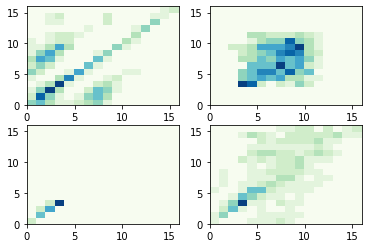

In [4]:
CH, CW, CS, CO = pyross.contactMatrix.UK()

## matrix of total contacts
C=CH+CW+CS+CO


fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

In [5]:
beta  = 0.036692            # infection rate 

gIa   = 1./7                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 

alpha = 0.3                 # fraction of asymptomatic infectives 
fsa   = 0.2                   # the self-isolation parameter   

sa    = 100*np.ones(M)      # arrival of new susceptibles
sa[0] = 1500

iaa   = 10*np.ones(M)       # daily arrival of new  asymptomatics
ep    = 0.01                # fraction of recovered who is susceptible



# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4

Ia_0 = np.zeros((M));  Ia_0[6:13]=4;  Ia_0[2:6]=2; Ia_0[13:16]=2
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (1.3199080176950944+0j)


126.0

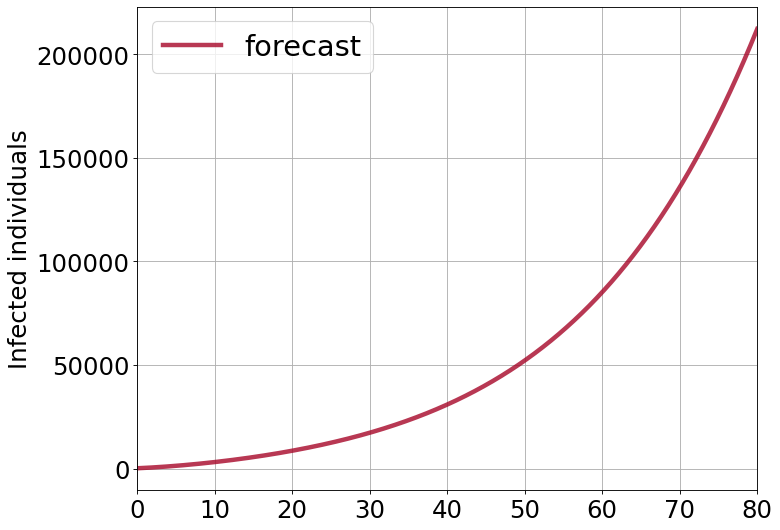

In [6]:
# duration of simulation and data file
Tf=80;  Nf=2000;  



# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa, 'sa':sa, 'iaa':iaa, 'ep':ep}
model = pyross.deterministic.SIRS(parameters, M, Ni)



# the contact structure is independent of time 
def contactMatrix(t):
    return C
# run model
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)


t = data['t']; IC  = np.zeros((Nf))
for i in range(2*M):
        IC += data['X'][:,M+i]
        

        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)

 
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); #plt.xlim(0, 40); plt.ylim(0, 9999);
#plt.savefig('/Users/rsingh/Desktop/2a.png', format='png', dpi=212)
IC[0]

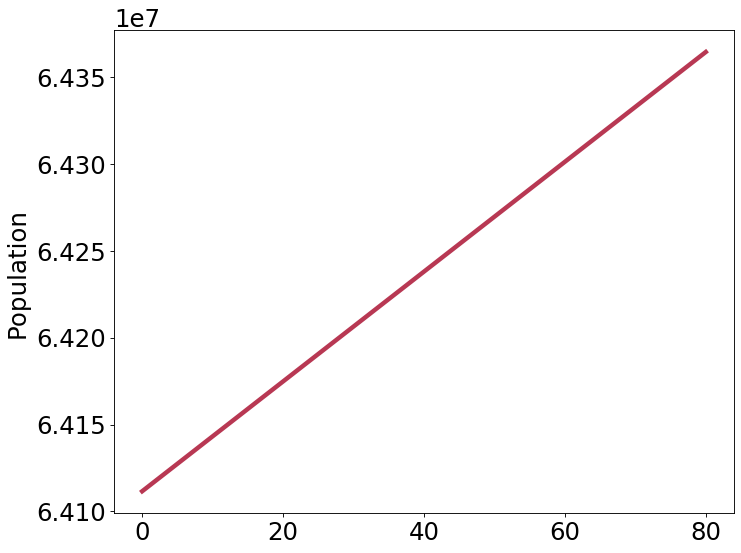

In [7]:
t = data['t']; Nit  = np.zeros((Nf))

for i in range(M):
        Nit += data['X'][:,3*M+i]
        

        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, Nit, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)

plt.ylabel('Population '); #plt.xlim(0, 40); plt.ylim(0, 9999);

